In [1]:
!pip install kaggle
!pip install torch torchvision

## Import PyTorch libraries

In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import zipfile
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.nn.functional as fun
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.autograd import Variable

In [3]:
print("GPU available: {}".format(torch.cuda.is_available()))
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

GPU available: True


To https://www.kaggle.com/ to apply for an account and log in

Enter the settings with the avatar in the upper right corner

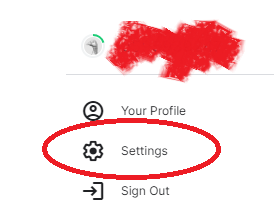

Create your own API key

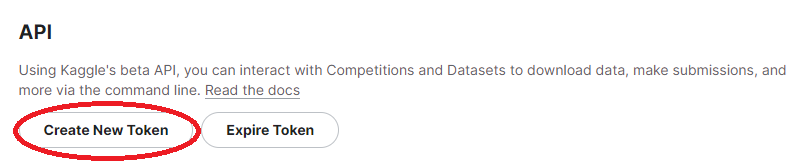

Username and key are marked with the key generated by yourself

## Load data (1%)
You can use the API from kaggle or download the data set from kaggle


In [4]:
from google.colab import files

# upload kaggle.json
uploaded = files.upload()


!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/animal-faces


Saving kaggle.json to kaggle (4).json
animal-faces.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
# 解壓縮
with zipfile.ZipFile('animal-faces.zip', 'r') as zip_ref:
    zip_ref.extractall("animal-faces")




In [6]:
# 讀取並顯示前幾個圖片
def show_images(images, cols=1, titles=None):
    assert((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1, n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)).astype(int), n + 1)
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

# 設置要顯示的圖片數量
num_images_to_show = 3

images = []
for dirname, _, filenames in os.walk('/content/animal-faces/afhq/train/cat'):
    for filename in filenames[:num_images_to_show]:
        img_path = os.path.join(dirname, filename)
        images.append(Image.open(img_path))

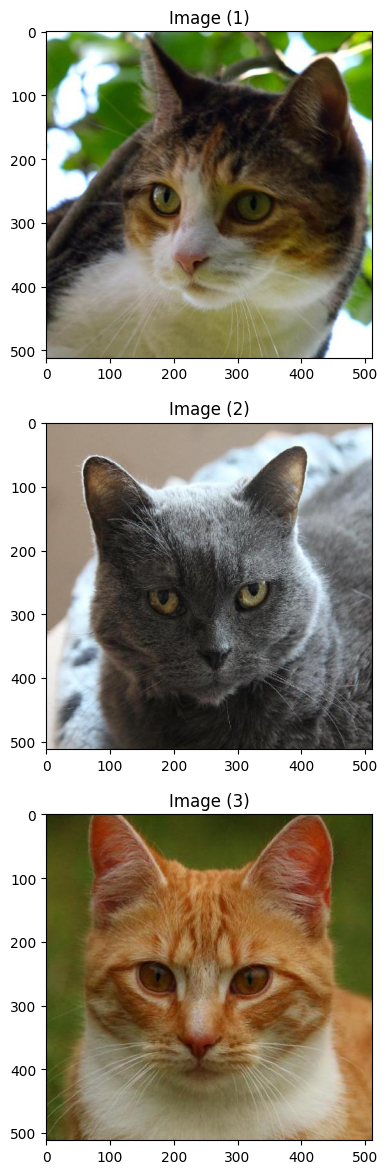

In [7]:
show_images(images, cols=3)

## Preprocessing (1%)
Transformers are essential to convert image data into the required format suitable for input into our model.

Define training and testing transforms, and consider using Normalize to standardize pixel values.

In [8]:
# 定義訓練時的數據轉換
train_transforms = transforms.Compose([
    #圖像調整
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root='/content/animal-faces/afhq/train', transform=train_transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

# 計算平均值和標準差
mean = torch.zeros(3)
std = torch.zeros(3)
for images, _ in dataloader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
mean /= len(dataloader.dataset)
std /= len(dataloader.dataset)

print(f'Mean: {mean}')
print(f'Std: {std}')

Mean: tensor([0.5023, 0.4600, 0.3995])
Std: tensor([0.2160, 0.2095, 0.2088])


train_Labels: tensor([2, 2, 1, 0, 2])


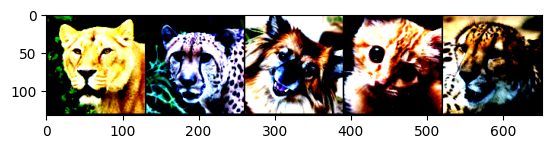

test_Labels: tensor([0, 2, 0, 2, 1])


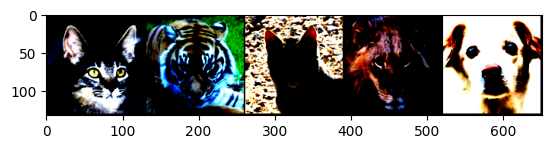

In [9]:
# 使用計算出的平均值和標準差進行正規化
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# 重新載入
train_dataset = datasets.ImageFolder(root='/content/animal-faces/afhq/train', transform=train_transforms)
test_dataset = datasets.ImageFolder(root='/content/animal-faces/afhq/val', transform=test_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

train_dataiter = iter(train_loader)
train_images, train_labels = next(train_dataiter)
print('train_Labels:', train_labels[:5])

# 顯示標準化圖像
imshow(torchvision.utils.make_grid(train_images[:5]))

test_dataiter = iter(test_loader)
test_images, test_labels = next(test_dataiter)
print('test_Labels:', test_labels[:5])

# 測試圖像
imshow(torchvision.utils.make_grid(test_images[:5]))

## Model buliding (1%)
"Build a convolutional neural network (CNN) model or pre-train model using PyTorch for image classification. The model should include at least three convolutional layers, and we will create a convolution kernel to achieve this."

(You can enhance model accuracy by defining appropriate loss functions and optimizers.)


In [10]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 全連接層
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 3)

    def forward(self, data):
        # 通過卷積層和ReLU激活函數
        data = self.pool(fun.relu(self.conv1(data)))
        data = self.pool(fun.relu(self.conv2(data)))
        data = self.pool(fun.relu(self.conv3(data)))
        # 攤平
        data = data.view(-1, 128 * 16 * 16)
        data = fun.relu(self.fc1(data))
        data = self.fc2(data)
        return data


In [11]:
model = SimpleCNN().to(device)
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.002)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32768, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=3, bias=True)
)


## Train model (1%)

Defining a Loss Function and Optimizer is crucial for our training process. We must specify the type of loss to measure the model's performance and determine the method for updating gradients during training.

(To enhance the model's generalization ability, you can use explore techniques such as learning rate decay, batch regularization, and dropout during the training process.)

In [12]:
# Learning Rate Decay
# 每個epoch後 學習率 * gamma
scheduler = StepLR(optimizer, step_size=1, gamma=0.8)
num_epochs = 16
batch = 32

In [13]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    # 開始時歸零梯度
    optimizer.zero_grad()

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # 損失平均分配
        loss = loss / batch
        # 反向傳播但不更新參數
        loss.backward()
        running_loss += loss.item() * batch  # 這裡乘以 batch_size 是為了計算整個 batch 的損失

        # batch後更新參數
        if (i + 1) % batch == 0 or (i + 1) == len(train_loader):
            # 更新參數
            optimizer.step()
            # 歸零梯度
            optimizer.zero_grad()

        if (i + 1) % batch == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss / batch:.4f}')
            running_loss = 0.0

    epoch_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

    scheduler.step()

Epoch [1/16], Step [32/915], Loss: 1.0974
Epoch [1/16], Step [64/915], Loss: 7.9644
Epoch [1/16], Step [96/915], Loss: 2.4092
Epoch [1/16], Step [128/915], Loss: 1.3692
Epoch [1/16], Step [160/915], Loss: 1.1052
Epoch [1/16], Step [192/915], Loss: 1.0892
Epoch [1/16], Step [224/915], Loss: 1.0941
Epoch [1/16], Step [256/915], Loss: 1.0791
Epoch [1/16], Step [288/915], Loss: 1.0482
Epoch [1/16], Step [320/915], Loss: 1.0208
Epoch [1/16], Step [352/915], Loss: 1.0975
Epoch [1/16], Step [384/915], Loss: 1.0761
Epoch [1/16], Step [416/915], Loss: 1.0591
Epoch [1/16], Step [448/915], Loss: 0.9537
Epoch [1/16], Step [480/915], Loss: 1.0341
Epoch [1/16], Step [512/915], Loss: 0.9524
Epoch [1/16], Step [544/915], Loss: 0.8998
Epoch [1/16], Step [576/915], Loss: 0.9292
Epoch [1/16], Step [608/915], Loss: 0.9294
Epoch [1/16], Step [640/915], Loss: 0.8675
Epoch [1/16], Step [672/915], Loss: 0.8109
Epoch [1/16], Step [704/915], Loss: 0.8293
Epoch [1/16], Step [736/915], Loss: 0.7609
Epoch [1/16], 

## Evaluate performance (2%)
After training the model, it's essential to assess its performance on unseen data. Follow these steps for a comprehensive evaluation:

Test Set Evaluation: Use a separate test dataset that the model hasn't encountered during training. This ensures the assessment of the model's generalization ability, gauging its predictive performance on new data.
showing test accuracy(2% over accuracy 60%)

In [14]:
def test(model, test_loader, criterion):
    #評估模式
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # 累計loss
            test_loss += criterion(outputs, labels).item()
            # 最高機率類別
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    print(f'Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_accuracy:.2f}%)')

# 在測試集上進行評估
test(model, test_loader, criterion)

Test set: Average loss: 0.0096, Accuracy: 1412/1500 (94.13%)
